#Mounting & Importing Libraries

In [ ]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino

/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation,RandomFlip,Rescaling
from tensorflow.keras.callbacks import EarlyStopping
import shutil
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from matplotlib import pyplot as plt

#Model
Which is explained very clearly [here](https://neurohive.io/en/popular-networks/vgg16/)

##Inputs

In [ ]:
IMAGE_SIZE = (512,512)
NUM_CLASSES = 3 
BATCH_SIZE = 32  

In [ ]:
df_train=pd.read_excel("train0-7.xlsx")
df_test=pd.read_excel("test0-7.xlsx")

In [ ]:
df_test

,Unnamed: 0,ImageID,ImageDir,Projection
0,0,5/117461681536540587607592076584888612953_wmoy...,5,PA
1,1,0/214260817085057432303623958907855926368_jrl2...,0,PA
2,2,4/144306045728819370188471558682816175107_vhmd...,4,PA
3,3,1/213096160366986458367121958911602047465_wble...,1,PA
4,4,4/280022667207150747197673782766436308679_15wi...,4,PA
...,...,...,...,...
4355,4355,1/201028909759225999897549410032918111027_-ruc...,1,PA
4356,4356,6/155634289149161267049279102303067537749_ba86...,6,L
4357,4357,2/282333874080047874618440451478871639364_1xiw...,2,PA
4358,4358,5/99711541869715028575308087414656016123_cysyz...,5,L


In [ ]:
datagen = ImageDataGenerator(validation_split = 0.2)
dir = '/content/drive/My Drive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef'
train_batches = datagen.flow_from_dataframe( #tomamos info de un df
    df_train, 
    directory=dir,
    x_col='ImageID',y_col='Projection',
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=BATCH_SIZE,
    subset = "training",
    seed=42,
    class_mode="categorical",)

Found 13951 validated image filenames belonging to 3 classes.


In [ ]:
valid_batches = datagen.flow_from_dataframe(df_train, directory=dir,
                                            x_col='ImageID',y_col='Projection',
                                            target_size=IMAGE_SIZE,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            subset = "validation",
                                            seed=42,
                                            class_mode="categorical",)

Found 3487 validated image filenames belonging to 3 classes.


##Data Augmentation & Model Definition

In [ ]:
#data_augmentation = Sequential([  #package: experimental.preprocessing
  Rescaling(1./255, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)), #NN work better with small values
  RandomFlip('horizontal'),
  RandomRotation(0.2),
])

In [ ]:
model = models.Sequential()
#model.add(data_augmentation)
conv_base = VGG16(weights="imagenet", include_top=False,
                  input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))  
conv_base.trainable = False 
model.add(conv_base)
model.add(layers.Flatten()) 
model.add(layers.Dense(256, activation="relu")) 
model.add(layers.Dense(NUM_CLASSES, activation="softmax")) 

58892288/58889256 [==============================] - 1s 0us/step


##Compilation & Trainning

In [ ]:
from keras.optimizers import Adam
adam = Adam(lr=0.0001)
model.compile(loss="categorical_crossentropy",
              optimizer=adam,
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 16, 16, 512)       14714688  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               33554688  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 48,270,147
Trainable params: 33,555,459
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
history=model.fit(train_batches, 
                  #steps_per_epoch=10, #Si no aclaras este parametro, sera la cantidad default (numero de imagenes de train / batch size)
                  validation_data = valid_batches,
                  epochs= 30,
                  workers=8,
                  callbacks=[EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)],
                  batch_size = BATCH_SIZE #Podes investigar este callback y otros
 )
model.save('VGG_notm1.h5')

Epoch 1/30
436/436 [==============================] - 585s 1s/step - loss: 1.2849 - accuracy: 0.9501 - val_loss: 0.1373 - val_accuracy: 0.9811
Epoch 2/30
436/436 [==============================] - 390s 889ms/step - loss: 0.0391 - accuracy: 0.9946 - val_loss: 0.1323 - val_accuracy: 0.9908
Epoch 3/30
436/436 [==============================] - 386s 880ms/step - loss: 0.0197 - accuracy: 0.9974 - val_loss: 0.1074 - val_accuracy: 0.9934
Epoch 4/30
436/436 [==============================] - 386s 881ms/step - loss: 0.0155 - accuracy: 0.9974 - val_loss: 0.1717 - val_accuracy: 0.9908
Epoch 5/30
436/436 [==============================] - 391s 891ms/step - loss: 0.0266 - accuracy: 0.9967 - val_loss: 0.1900 - val_accuracy: 0.9923
Epoch 6/30
436/436 [==============================] - 389s 887ms/step - loss: 0.0139 - accuracy: 0.9983 - val_loss: 0.1658 - val_accuracy: 0.9914
Epoch 7/30
436/436 [==============================] - 388s 883ms/step - loss: 0.0350 - accuracy: 0.9968 - val_loss: 0.1866 - va

Early Stopping --> monitor 'val_loss' or 'accuracy_loss'
[More Info](http://alexadam.ca/ml/2018/08/03/early-stopping.html#:~:text=Problems%20With%20Early%20Stopping,increase%20as%20validation%20loss%20decreases.&text=The%20issue%20is%20that%20validation,worse%20as%20validation%20accuracy%20improves.) 

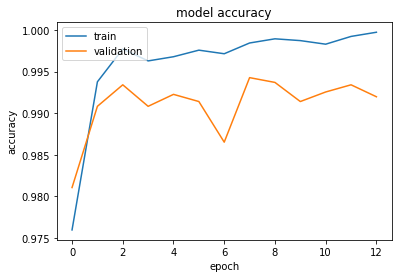

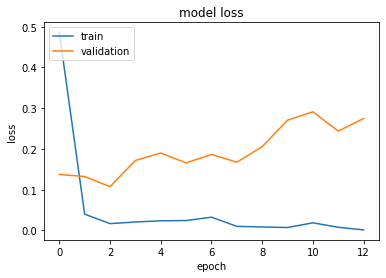

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##Test

In [ ]:
dir = '/content/drive/My Drive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef'
test_datagen = ImageDataGenerator()
test_batches = test_datagen.flow_from_dataframe(
    df_test, 
    directory=dir,
    x_col='ImageID',y_col='Projection',
    target_size=IMAGE_SIZE,
    shuffle=False,
    batch_size=1,
    seed=42,
    class_mode="categorical",#, validate_filenames=False
    )

Found 4360 validated image filenames belonging to 3 classes.


In [ ]:
model = load_model('VGG_notm1.h5')

In [ ]:
#Calculamos la matriz de predicciones
result_test=model.predict(test_batches, verbose=1)
print(result_test.shape)

4360/4360 [==============================] - 1169s 268ms/step
(4360, 3)


In [ ]:
#Obtenemos el nombre de clase asociado a cada indice 
classes_dict = dict(zip(train_batches.class_indices.values(),train_batches.class_indices.keys()))
classes_dict

{0: 'AP_horizontal', 1: 'L', 2: 'PA'}

In [ ]:
#Obtenemos el índice de mayor score en cada fila (cada imagen)
preds = result_test.argmax(axis=-1)

In [ ]:
#Obtenemos el nombre de clase asignado a cada clase
preds_classes = [classes_dict[p] for p in preds]

In [ ]:
#Evaluar cuantas predicciones hay de cada clase
pd.Series(preds_classes).value_counts()

PA               2708
L                1430
AP_horizontal     222
dtype: int64

In [ ]:
import numpy as np
#Obtenemos el nombre de clase de la etiqueta verdadera (groun-truths)
gts = np.array([classes_dict[p] for p in test_batches.classes])

#[Model Evaluation - Metrics](https://https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826)
Para poder comparar diferentes modelos, debemos escoger una única metrica principal. En este nos quedamos con el F1 - score, que tiene la ventaja de incluir precision y recall. 


*   **Precision o Valor Predictivo Positivo (VPP):** Imágenes pertenecientes a un grupo/ Imágenes clasificados como pertenecientes a ese grupo. (TP/TP+FP)
*   **Recall o Sensibilidad:** (TP/TP+FN)
*   **F1 - Score**
 
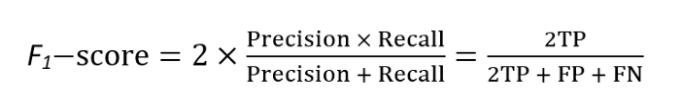



In [ ]:
#Evaluamos métricas de clasificación
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(gts,preds_classes))


               precision    recall  f1-score   support

AP_horizontal       0.96      0.99      0.97       217
            L       0.99      1.00      1.00      1427
           PA       1.00      0.99      1.00      2716

     accuracy                           0.99      4360
    macro avg       0.99      0.99      0.99      4360
 weighted avg       0.99      0.99      0.99      4360



In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Matriz de confusión',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center", fontsize=20,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta verdadera', fontsize=20)
    plt.xlabel('Predicción del modelo', fontsize=20)
    plt.show()

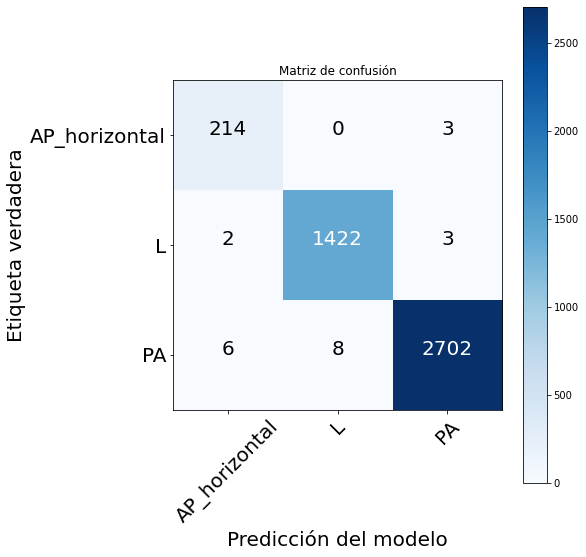

In [ ]:
confusionMatrix = confusion_matrix(gts,preds_classes)

plot_confusion_matrix(confusionMatrix,test_batches.class_indices.keys())

Para una clasificación no binaria, tenemos diferentes maneras de incorporar los resultados en una única métrica: 
*   Micro F1
*   Macro F1: Promedio Normal entre clases
*   F1 Ponderada: Promedio ponderado (entre clases, según la cantidad de imágenes por clase o algún otro criterio, por ejemplo a que clase le queremos dar mayor importancia).

In [ ]:
#Macro F1 
MacroF1 = (0.92+0.99+0.99)/3
MacroF1

0.9666666666666668

In [ ]:
#Weighted F1 - Según cantidad de elementos por clase
WeighF1 = (217*0.92+1427*0.99+2716*0.99)/4360
WeighF1

0.9865160550458716

##[AUC - ROC Curve](https://https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)
AUC: Area under the curve.
ROC: Reciever Operating Caracteristics.
Nos da la capacidad del modelo de distinguir entre clases. Cuanto mayor es el AUC (máx. = 1), mejor clasifica. Si vale 0.5, implica que el modelo no tiene capacidad de clasificar.

Para un modelo multiclase, debemos usar la metodología uno vs todos, es decir, un gráfico por clase.

In [ ]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

In [ ]:
y_test = pd.get_dummies(gts).to_numpy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


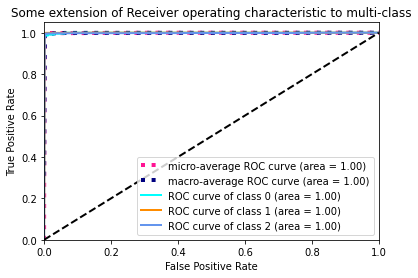

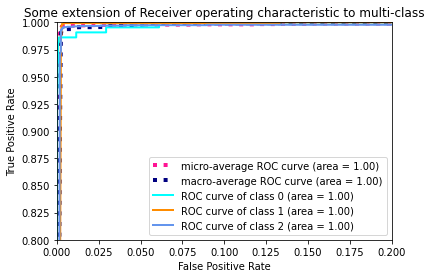

In [ ]:
y_score = result_test
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(NUM_CLASSES):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= NUM_CLASSES

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
Y_test = pd.get_dummies(gts).to_numpy()
y_score = result_test

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(NUM_CLASSES):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])


# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 1.00


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=1.00')

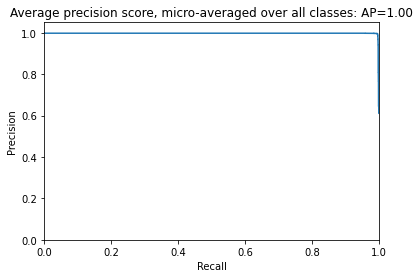

In [ ]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

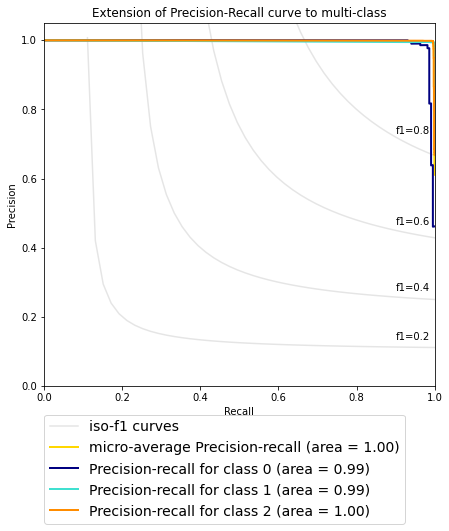

In [ ]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(NUM_CLASSES), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()

In [ ]:
df_test["Pred"] = preds_classes

In [ ]:
df_test

,Unnamed: 0,ImageID,ImageDir,Projection,Pred
0,0,5/117461681536540587607592076584888612953_wmoy...,5,PA,PA
1,1,0/214260817085057432303623958907855926368_jrl2...,0,PA,PA
2,2,4/144306045728819370188471558682816175107_vhmd...,4,PA,PA
3,3,1/213096160366986458367121958911602047465_wble...,1,PA,PA
4,4,4/280022667207150747197673782766436308679_15wi...,4,PA,PA
...,...,...,...,...,...
4355,4355,1/201028909759225999897549410032918111027_-ruc...,1,PA,PA
4356,4356,6/155634289149161267049279102303067537749_ba86...,6,L,L
4357,4357,2/282333874080047874618440451478871639364_1xiw...,2,PA,PA
4358,4358,5/99711541869715028575308087414656016123_cysyz...,5,L,L


In [ ]:
df_test["result"] = df_test["Projection"]==df_test["Pred"]

In [ ]:
df_test_bad=df_test[df_test["result"]==False]

In [ ]:
df_test_bad

,Unnamed: 0,ImageID,ImageDir,Projection,Pred,result
76,76,4/51660009030804800622517791419411123073_-6v4c...,4,PA,L,False
94,94,5/26058313305469716031660539225317181435_luhas...,5,PA,L,False
505,505,3/226684531336069926032758333606592365808_h5kt...,3,L,AP_horizontal,False
532,532,0/125208930338141968501244764499259500218_arhz...,0,PA,AP_horizontal,False
559,559,3/322729003998044809439852710028606111975_arku...,3,L,PA,False
1021,1021,2/109632595289119302525510049632709306408_plcd...,2,AP_horizontal,PA,False
1046,1046,4/173269808771409448416724194334398370630_8i9u...,4,PA,L,False
1081,1081,7/312592249394142578724510611760077752354_-vxo...,7,AP_horizontal,PA,False
1172,1172,2/211287158965341609617858426519111617565_fo6y...,2,L,AP_horizontal,False
1308,1308,1/295156438918105293116520723412860972512_d65g...,1,PA,AP_horizontal,False


#Analisis de Predicciones incorrectas

In [ ]:
%cd /content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino

/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino


Ground Truth: PA
Prediction: L


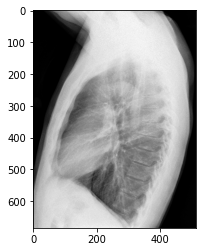

In [ ]:
from skimage.io import imread
ROW = 76
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: L


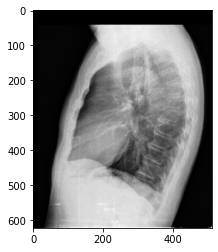

In [ ]:
ROW = 94
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: L
Prediction: AP_horizontal


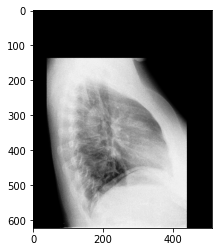

In [ ]:
ROW = 505
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: AP_horizontal


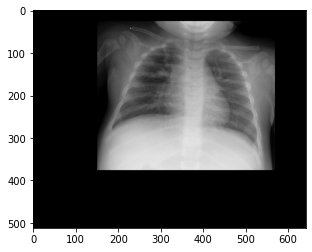

In [ ]:
ROW = 532
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: L
Prediction: PA


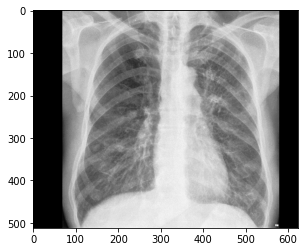

In [ ]:
ROW = 559
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: AP_horizontal
Prediction: PA


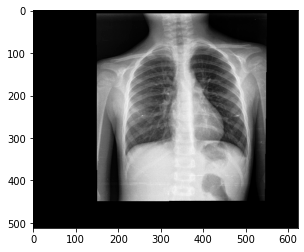

In [ ]:
ROW = 1021
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: L


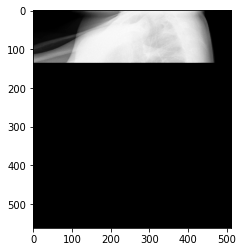

In [ ]:
ROW = 1046
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: AP_horizontal
Prediction: PA


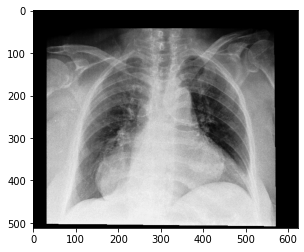

In [ ]:
ROW = 1081
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: L
Prediction: AP_horizontal


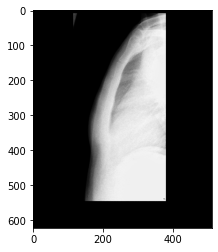

In [ ]:
ROW = 1172
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: AP_horizontal


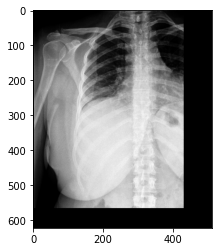

In [ ]:
ROW = 1308
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: L


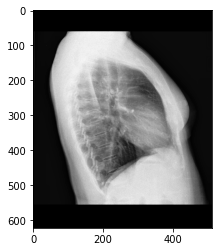

In [ ]:
ROW = 1326
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: L


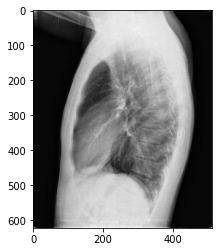

In [ ]:
ROW = 1389
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: L
Prediction: PA


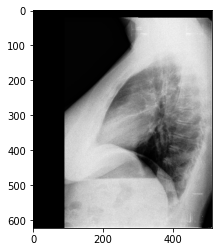

In [ ]:
ROW = 1873
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: AP_horizontal


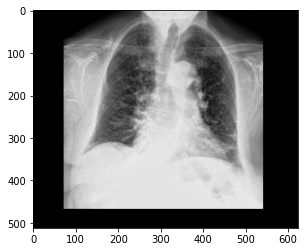

In [ ]:
ROW = 3225
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: L


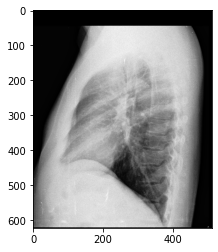

In [ ]:
ROW = 3356
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: L


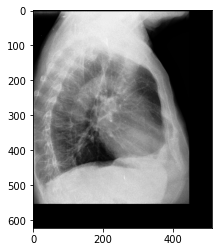

In [ ]:
ROW = 3497
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: L
Prediction: PA


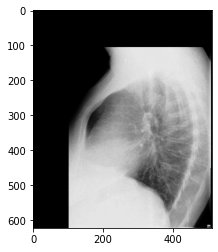

In [ ]:
ROW = 3711
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: AP_horizontal


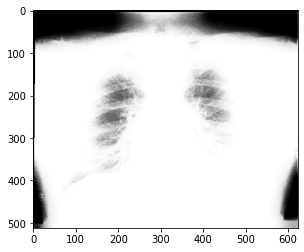

In [ ]:
ROW = 4126
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: AP_horizontal
Prediction: PA


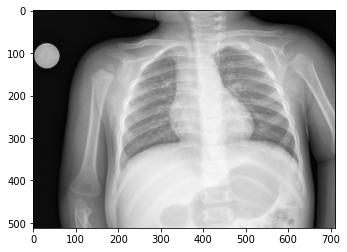

In [ ]:
ROW = 4130
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: AP_horizontal


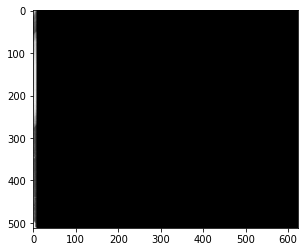

In [ ]:
ROW = 4171
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])

Ground Truth: PA
Prediction: L


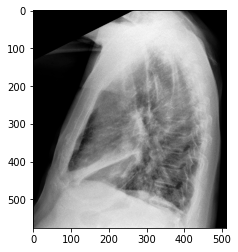

In [ ]:
ROW = 4309
path_read = '/content/drive/MyDrive/2020 - Quinto Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/' + df_test["ImageID"].values[ROW]
imagen = imread(path_read)
plt.imshow(imagen[:,:,1],cmap=plt.cm.Greys_r)
print('Ground Truth: '+ df_test["Projection"].values[ROW]+'\n'+'Prediction: ' +df_test["Pred"].values[ROW])